# Draft Notebook

#### Problem

After an important document from the Generic Space Empire (GSC) was stolen, Non-Copyrighted Alien spies began complex attacks against the prize of the GSC, the space station. These attacks are more complex than before, requiring a compromising of a combination of components, often distributed across workstations. In order to defend against these attacks, the GSC has hired our team to develop a methodology to characterize the faults found within the system after an attack. Below is an illustration of our workstation system. 
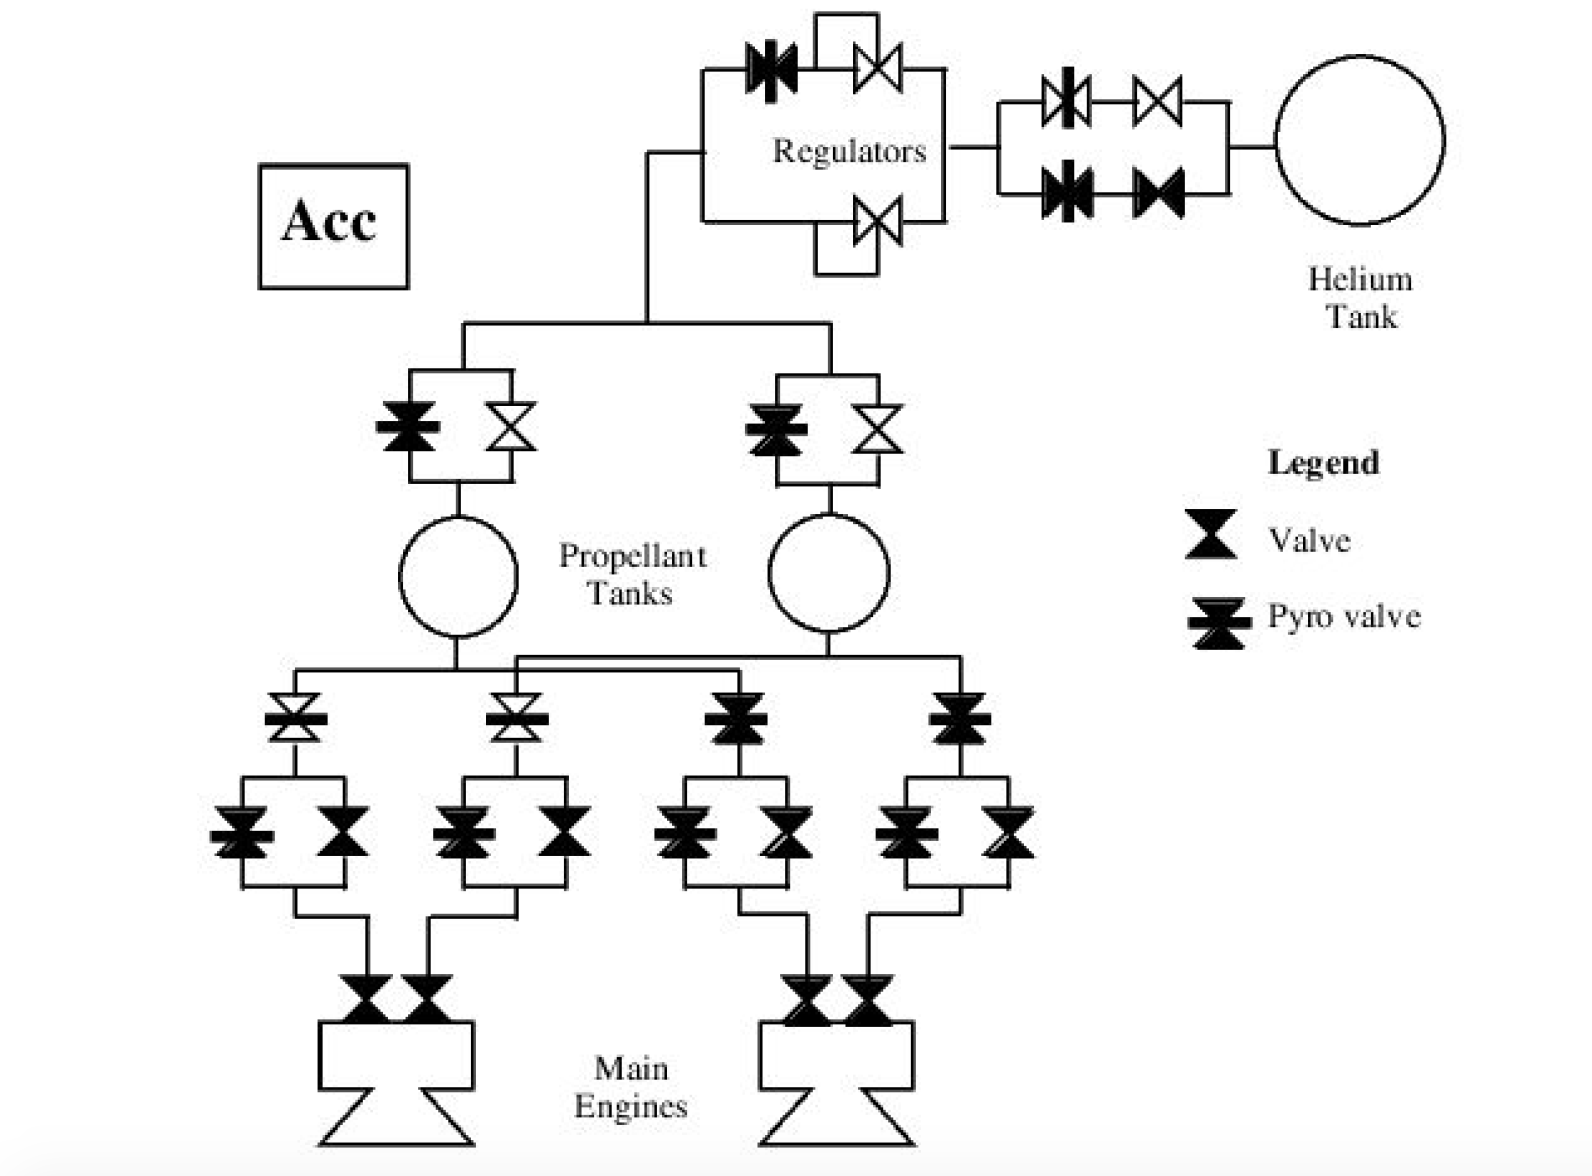
The valves are the actuators in the system, and can be open or closed. We would only have propulsion if there is an open path from the helium tank to the propellant tank, and an open path from the propellant tank to the engine. 

The valves can be set, but might be faulty. If the valve is norminal, then it will be at the commanded state. Alternatively, it could be stuck open, or stuck closed. The probability of each type of actuator being in different fault states is given as follows:
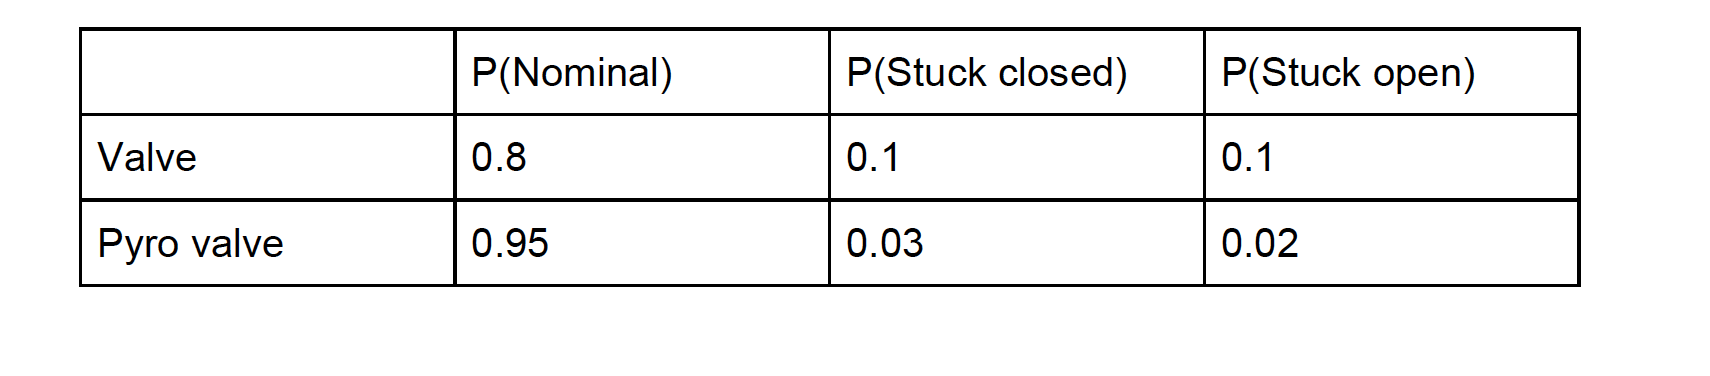
We have probed the system, setting the valves in solid black closed and the others open. However, we observe that there is acceleration, due to one or more engines. We need to decide what mode each valve is in: norminal, stuck closed, or stuck open.

We can formulate this problem as a search problem, with a constraint satisfaction problem model. Our model will represent an input state, which is based off a set of variable assignments, and a list of conditions for a state to be a solution. These conditions will be defined by using a set of constraints on the aforementioned variables. 

### Motivation 
Mode is a term for behavior of a system. All components in a system have behaviors associated with modes, as well as modes that are unknown to the component. Mode estimation takes in the mode, state, and observable variables and tries to determine a diagnoses for what is causing the outcome state of the system. Mode estimation is a very useful tool for characterizing what has occurred in a system that could produce a given end state. 

### Formulation: Optimal CSP 
Mode estimation and model-based diagonsis can be framed as an optimal CSP which defined by $< X, r(x), CSP>$ where CSP is a constraint satisfaction problem as usual, $X$ is a subset of its variables, namely \textit{decision variables}, and $r(x)$ is a reward or utility function defined only over $X$. In this case, the goal is to maximize $r(x)$ to get most probable mode estimation. Consider a toy example for our bigger problem, from helium tank to regulator:
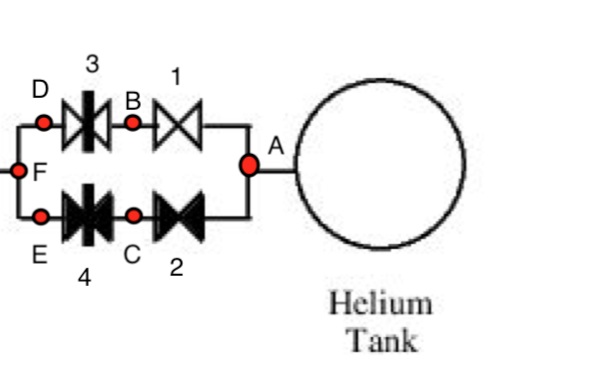
In this case, the modes of 1, 2, 3 and 4 are decision variables, each with domain True (nominal/working) or False (stuck/broken). Our utility function is defined as $g(x) = f(x) + h(x)$ where $f(x)$ is the probability of partially assigned decision variables taking their repspective values (assuming independence), and $h(x)$ is the heuristic value of unassigned decision variables untill full assignment. Note, we want to maximize the probability, thus  heuristic function need to be overestimate to assure admissibility of the model. Other, non-decision variables, also known as state variables are A, B, C, D, E and F, each with domain True (has flow) or False (no flow).
#### The goal is to enumerate the highest utility combination of these decision variables, such that all constraints are satisfied. 

Build an OptimalCSP model to represent our toy example. Note: to test our model, we say that there is flow from helium tank but no flow in output F. Thus, we need estimate mode for each valve to cause this problem. 

#### Propositional Logic of Our Model

We note that we can implement our model using methods taught in the class, using valve 1 as an example, we have following propositional sentences:

    (mode(valve1) = ok or mode(valve1) = stucked) and
    
    not (mode(valve1) = ok and mode(valve1 = stucked) and
    
    (mode(valve1) = ok implies 
    
        (B = has flow iff A = has flow) and (B = not flow iff A = no flow))
        
We then can reduce down this propositional sentences into CNF form of constraints:

    (valve1 = 1 or valve1 = 0) and
    
    (valve1 = 0 or ((B = 0 or A = 1) and (B = 1 or A = 0))
    
    = (not valve1 or not B or A) and (not valve1  or B or not A)
    
Instead of implementing our model using above method, we decided on a different approach because we weren't aware of above method until last week it was present in the lecture which by that time we have already finished the model. Similarily as the class method, we using different variables to represent type of variables, with integer representing the valve and letter representing the link to valve (flow). The difference lies on the way we condition our constraints on the flow variable while incorporating valve value. For instance, we know that flow A is always True, so we have one constraint on variable $A$:

    (A = 1)
   
And, $B$'s flow value is dependent on whether valve 1 is acting normal or the presence of input flow from A.

    (B = 1 and Valve1 = 1 and A = 1) or (B = 0 and Valve1 = 0) or (B = 0 and A = 0)

Similarily for $C$'s case, it is dependent on whether valve 2 is acting normal or the presence of input flow from C.

    (C = 0 and Valve2 = 1) or (C = 1 and Valve2 = 0 and A = 1)
    
For $D$, it is dependent on whether valve 3 is acting normal, or the presence of input flow from B. And since for this toy example, we are said that output $F$ has no flow, therefore $D$ should always be 0.

    (D = 0 and Valve3 = 0) or (D = 0 and B = 0)

Similarily, for $E$, it is dependent on whether valve 4 is acting normal, or the presence of input flow from C

    (E = 0 and Valve2 = 1)
 
F has no flow, thus no flow from D and E

    (F = 0 and D = 0 and E = 0)

The above constraints are joint by AND, in other words consistency check makes sure that all of above constraints are met. Our approaches are based on the fact that we reason out and reduce down our problem initially, before we model it into an CSP question.

In [1]:
import numpy as np
from optimalCSP import *
import time

In [2]:
# state and decision varibles as described above
state_vars = ["A", "B", "C", "D", "E", "F"]
decision_vars = ["1", "2", "3", "4"]
variables = decision_vars + state_vars

# decision variables = [True, False] represents [Normal, Stuck]
# state variables = [True, False] represents [has flow, no flow]
domains = {}
for var in variables:
    domains[var] = [True, False]
    
constraints = {}
# each state variable has constraints

# A always has flow
constraints["A"] = [{"A": True}]

# B's value is dependent on whether valve 1 is acting normal or the presence of input flow from A
constraints["B"] = [{"B":True, "1":True, "A":True}, {"B":False, "1":False}, {"B": False, "A": False}]

# C's value is dependent on whether valve 2 is acting normal or the presence of input flow from A
constraints["C"] = [{"C":False, "2":True}, {"C":True, "2":False, "A":True}]

# set output of toy example to be False to test 
# D's value is dependent on whether valve 3 is acting normal, or the presence of input flow from B
constraints["D"] = [{"D":False,"3":False}, {"D":False, "B":False}]
# E's value is dependent on whether valve 4 is acting normal, or the presence of input flow from C
constraints["E"] = [{"E":False,"4":True}]
# F has no flow, thus no flow from D and E
constraints["F"] = [{"F":False, "D":False, "E":False}]

# denote valve being open or close
states = {"1": 1, "2": 0, "3":1, "4": 0}
# denote type of valves: 0 being valve, 1 being pyro
types = {"1": 0, "2": 0, "3": 1, "4": 1}
# probility distribution table
valve_prob = [0.8, 0.1, 0.1]
pyro_prob = [0.95, 0.03, 0.02]
probs_table = [valve_prob, pyro_prob]

In [3]:
# reward function f = g(x) + h(x)
def score_f(assignment):
    score = 0
    for var in decision_vars:
        valve_type = types[var]
        prob_dist = probs_table[valve_type]
        state = states[var]
        if var in assignment:
            is_normal = assignment[var]
            if is_normal:
                score += np.log(prob_dist[0])
            else:
                if state == 1:
                    # suppose to be open, but detect not normal, thus stuck close
                    score += np.log(prob_dist[1])
                else:
                    # suppose to be close, but detect not normal, thus stuck open
                    score += np.log(prob_dist[2])

        else:
            # estimate heuristic
            # overestimate 
            score += np.max(np.log(prob_dist))
    return score

def interpret_assignment(assign):
    # convert code assignment to mode assignment for human understanding
    new_assignment = {}
    
    for var in assign.keys():
        is_normal = assign[var]
        is_open = states[var]
        if is_normal:
            new_assignment[var] = "Norminal"
        else:
            # not normal, currently expected open, final is stuck closed
            if is_open:
                new_assignment[var] = "Stuck Closed"
            else:
                # not normal, currently expected close, final is stuck open
                new_assignment[var] = "Stuck Open"
    return new_assignment

In [4]:
# a optimalCSP object represents our toy example
optimal_csp = OptimalCSP(variables, domains, constraints, decision_vars, score_f)

### Simple Search
We can first try a simple search algirthm (brute force) to solve it. In this case, we would compute all possible valid combinations of assignement for each valve, and find top $k$ most probable assignments. 

In [5]:
def simple_search(csp):
    queue = [{}]
    num_check = 0
    expanded = []
    all_assign = []
    
    # search all possible assignment
    # until queue is empty
    while len(queue) > 0:
        assign = queue.pop(0)
        expanded.append(assign)
        # one possible assignment
        if len(assign) == len(csp.vars):
            all_assign.append(assign)
        else:
            # branch out by finding one unassigned var
            unassigned_var = None
            for var in csp.vars:
                if var not in assign:
                    unassigned_var = var
                    break
        
            # try all domain value to the unassigned var found
            for value in csp.domains[unassigned_var]:
                local_assignment = assign.copy()
                local_assignment[var] = value
                num_check += 1
                if csp.consistency_check(local_assignment):
                    queue.append(local_assignment)
        
    return all_assign, num_check
        

def keep_assign_decision(assignment):
    # given assignment to all variables, including decision and state
    # we only keep decision ones, since those are the ones we care about to determine the mode
    new_assignment = {}
    for var in assignment.keys():
        if var in states:
            new_assignment[var] = assignment[var]
    return new_assignment

def generate_candidate(assignment):
    # based on valid assignement of mode found by search algorithm
    # generate possible faulty valve
    candidates = []
    for var in assignment.keys():
        if not assignment[var]:
            candidates.append(var)
    return candidates


In [6]:
# for simple search we also need to account for sort prob after we find all possible assign
start_time = time.time()
all_assigns, num_check= simple_search(optimal_csp)
new_assigns = []
keyi_prob = {}
count = 0
# compute score all possible solutions found using simple search
for assignment in all_assigns:
    new_assign = keep_assign_decision(assignment)
    prob = np.e**score_f(new_assign)
    new_assigns.append(new_assign)
    keyi_prob[count] = prob
    count += 1

# sort prob score from largest to smallest
sorted_prob = sorted(keyi_prob.items(), key=lambda x: x[1], reverse=True)
# find top 5
top_5s = sorted_prob[:5]
# report statistics
run_time = time.time() - start_time
for i in range(len(top_5s)):
    assign_i, prob = top_5s[i]
    assign = new_assigns[assign_i]
    print ("Top {} simple search assignment: {}".format(i+1, interpret_assignment(assign)))
    print ("Probability of such assignment is :", prob)
    print ("Possible faulty candidates detected are:", generate_candidate(assign))
    print ()
print ("Number of consistency check: ", num_check)
print ("Total run time for simple search is {} seconds".format(run_time))

    

Top 1 simple search assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.07220000000000003
Possible faulty candidates detected are: ['1']

Top 2 simple search assignment: {'1': 'Norminal', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.01824000000000001
Possible faulty candidates detected are: ['3']

Top 3 simple search assignment: {'1': 'Stuck Closed', '2': 'Stuck Open', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.009025000000000014
Possible faulty candidates detected are: ['1', '2']

Top 4 simple search assignment: {'1': 'Norminal', '2': 'Stuck Open', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.002280000000000003
Possible faulty candidates detected are: ['2', '3']

Top 5 simple search assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.0

We can see that this simple search algorithm grows exponetially with sizes of variables and domain range, and thus it is very computationally expensive for our original problem as we need to find all possible solutions first then find top $k$. Alternatively, we can utilize our reward function that assures the adimissible property of the model, in other words while we search a possible valid assignment, we can always choose the most highly likely partially assigned one to expand, and stop when we find top $k$ most probable ones. This is essentially $\textbf{constraint-based A*}$ which is a best-first search algorithm. It searches through a graph, and can find paths of minimum cost or greatest reward. 

### Constraint-based A*     
We use A* to search in the large state space graph shown before, with the only exception that we only search over the decision variales. When we reach a full assignment of decision variables, we then check the remaining non-decision varibles to see if we can come up with an assignment to them that satisfies all of them. 

In [7]:
def cba(optimal_csp):
    start_time = time.time()
    queue = [{}]
    expanded = []
    top_5_assign = []
    num_check = 0

    while len(queue) > 0:
        # we have found top 5 complete, consistent assignment, return
        if len(top_5_assign) >= 5:
            return top_5_assign, num_check, time.time() - start_time
        
        # branch out from current assignment
        assign = queue.pop(0)
        expanded.append(assign)
        # check all decision variables have been assigned
        is_full_assign, non_assigned_var = check_full_assignment(assign)
        
        if is_full_assign:
            # all decision variables have been assigned and is consistent so far
            csp_assignment, num_check = optimal_csp.backtrack_search(assign, num_check)
            if csp_assignment is not None:
                # found one valid assignment
                top_5_assign.append(assign)
        else:
            assert(non_assigned_var is not None)
            # branch out by trying all domain values for unassinged var 
            nbrs = split_on_var(assign, non_assigned_var, optimal_csp)
            for nbr in nbrs:
                if nbr not in expanded:
                    queue.append(nbr)

        # update queue, so highest prob comes first
        queue = sort_priority(queue, optimal_csp)

    run_time = time.time() - start_time
    return top_5_assign, num_check, run_time

def check_full_assignment(assignment):
    # check if all decision variables has been assigned to some values
    for var in decision_vars:
        if var not in assignment:
            return False, var
    return True, None

def split_on_var(assignment, non_assigned_var, csp):
    # search tree split on variables, 
    # in other words, choose successor state by picking one of unassigned var
    # and try all of its domain
    
    queue = []
    for value in csp.domains[non_assigned_var]:
        local_assignment = assignment.copy()
        local_assignment[non_assigned_var] = value
        queue.append(local_assignment)
    #print ("split", queue)
    return queue

def sort_priority(queue, optimal_csp):
    # sort queue from largest to smallest log probability
    # using reward function defined earlier
    priority_queue = []
    for assignment in queue:
        score = optimal_csp.reward_f(assignment)
        priority_queue.append((score, assignment))
    
    priority_queue = sorted(priority_queue, key=lambda x: x[0], reverse=True)

    new_queue = []
    for s, assign in priority_queue:
        new_queue.append(assign)
    return new_queue

In [8]:
top_5_assignments, num_check, run_time= cba(optimal_csp)
for i in range(len(top_5_assignments)):
    assign = top_5_assignments[i]
    print ("Top {} cba* assignment: {}".format(i+1, interpret_assignment(assign)))
    print ("Probability of such assignment is :", np.e**score_f(assign))
    print ("Possible faulty candidates detected are:", generate_candidate(assign))
    print ()
print ("Number of consistency check overall: {}".format(num_check))
print ("Total runtime for CBA* search is {} seconds".format(run_time))


Top 1 cba* assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.07220000000000003
Possible faulty candidates detected are: ['1']

Top 2 cba* assignment: {'1': 'Norminal', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.01824000000000001
Possible faulty candidates detected are: ['3']

Top 3 cba* assignment: {'1': 'Stuck Closed', '2': 'Stuck Open', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.009025000000000014
Possible faulty candidates detected are: ['1', '2']

Top 4 cba* assignment: {'1': 'Norminal', '2': 'Stuck Open', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.002280000000000003
Possible faulty candidates detected are: ['2', '3']

Top 5 cba* assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.002280000000000003
Possible faulty candidates 

It makes sense that the most highly likely mode assignment for our toy problem is having valve 1 broken while rest of the valves working properly, and then having valve 3 broken while rest of the valves working properly. Because we know that top path is open, we should have output flow at $F$, but now we don't have output flow, this means that the most likely faulty valves come from the top path. And based on the probability table, valve 1 (standard valve) is more likely to be stuck closed than valve 3 (pyro valve). These are top 2 most likely faulty valves. For the rest of possibility, it only comes from that one of the valves in the bottom path are stuck open with the other remain norminal (close) so that we still don't have flow going through in the bottom path. Using same logic, the next possible faulty ones are valve 1 stuck close and valve 2 stuck open, so we still have top path having no flow and the bottom path having no flow, and so on. 

The constraint-based A* will solve the problem at hand, but it has one drawback: it can repeatedly keep searching over problematic areas of our search space. One way to solve this is  to introduce conflict set, which keeps track of conflicts resulted from tried assigned so far, and avoid to search any assignment that include one of conflicts, as we know it won't work from our earlier search.

### Conflict-directed A*
Conflict-directed A* solves above problem, by not repeatedly exploring states that all won't work for the same reason, known as conflict. Once we discover the conflicts, we can remove any states in $Q$ that manifest the conflict. Also, jump over the conflict by using $\textbf{constitunt kernel}$, where each assignment in the constitunt kernel is guarenteed to resolve the conflict. 

In [9]:
def cda(optimal_csp,output, states):
    start_time = time.time()
    queue = [{}]
    conflicts = []
    expanded = []
    top_5s = []
    num_check = 0
    while len(queue) > 0:
        if len(top_5s) >= 5:
            # found top 5 complete, consistent assignment
            return top_5s, num_check, time.time() - start_time
        
        assign = queue.pop(0)
        expanded.append(assign)
        is_full_assign, non_assigned_var = check_full_assignment(assign)
        if is_full_assign:
            # full assignment to decision variables, check consistency for state variables
            csp_assignment, num_check = optimal_csp.backtrack_search(assign, num_check)
            
            if csp_assignment is not None:
                # found one consistent assignment to all variables
                top_5s.append(assign)
            else:
                # there is a conflict, update queue that manefist the conflict
                queue,conflicts = remove_conflict(assign, queue,output,conflicts, states)
        else:
            # try first to resolve the conflict
            is_resolved, unresolved_conflict = resolved_conflicts(conflicts, assign, optimal_csp)
            if is_resolved:
                # resolvable, so we can split on var like cba
                nbrs = split_on_var(assign, non_assigned_var, optimal_csp)
            else:
                # unresolvable, then split by conflict by using kernel
                nbrs = split_on_conflict(assign, unresolved_conflict, optimal_csp)
                
            for nbr in nbrs:
                if nbr not in expanded:
                    queue.append(nbr)

        queue = sort_priority(queue, optimal_csp)

    return top_5s, num_check, time.time() - start_time



def remove_conflict(conflict, queue,output,conflict_list, states):
    ## output is output flow of circuit: True means there is a flow, False means no flow
    ## remove any states in Q that manifest conflict
    ## find conflict order first 
    issue=[]
    temp_issue=[]
    final_issue={}
    
    while len(issue)==0:
        # since right now decisision vars are from 1 to 4
        for var in range(4,0,-1):
            temp_issue=[]
            str_var=str(var)
            num_var=var
            
            # convert our variable assignment to interpret with output result
            # when there is flow in output, we should not expect a flow 
            # on the last partial path to the output, and vice versa
            is_normal = conflict[str_var]
            is_open = states[str_var]
            # valve is open, and nominal: has flow
            if is_normal and is_open:
                expected = 1
            elif is_normal and not is_open:
                # no flow
                expected = 0
            elif not is_normal and is_open:
                # stuck close
                expected = 0
            else:
                # broken, and state is close
                # stuck open
                expected = 1
            
            # check consistent with expected output
            if expected !=output:
                while num_var>0:
                    temp_issue.append(num_var)
                    num_var=num_var-2
                if temp_issue not in conflict_list:
                    issue=temp_issue
                    break
    
    for each in issue:
        each_string=str(each)
        final_issue[each_string]=conflict[each_string]
         
        
    conflict_list.append(final_issue)
    
    
    # remove anything on the queue that contains conflict
    new_queue = []
    for assignment in queue:
        if not final_issue.items() <= assignment.items():
            new_queue.append(assignment)
    return new_queue,conflict_list



def build_conflict_kernel(conflict, csp):
    # build a constituent kernel as described in the note for the conflict
    kernel = {}
    # conflict: not ("1"=True and "2"=True)
    # resolve t ("1" = False) or ("2"=False)
    for var in conflict.keys():
        value = conflict[var]
        # since we only have either True or False
        kernel[var] = not value
    return kernel


def resolved_conflicts(conflicts, assignment, csp):
    kernels = []
    for conflict in conflicts:
        # build a kernel for each conflict
        kernel = build_conflict_kernel(conflict, csp)
        kernels.append(kernel)
        
    for i in range(len(kernels)):
        k = kernels[i]
        is_resolved = False
        # check if any one of variable is resolved for each kernel
        # resolved means: kernel value of var is same as our assignment of var
        for var in k:
            if var in assignment:
                # check resolvable
                if k[var] == assignment[var]:
                    is_resolved = True
                    break
            
        if not is_resolved:
            # ith kernel not resolvable, so conflict i is returned
            return False, conflicts[i]
    return True, None

def split_on_conflict(assignment, unresolved_conflict, csp):
    kernel = build_conflict_kernel(unresolved_conflict, csp)
    new_queue = []
    for var in kernel.keys():
        value = kernel[var]
        local_assignment = assignment.copy()
        # self-consistent
        if var not in local_assignment:
            local_assignment[var] = value
            new_queue.append(local_assignment)
    return new_queue

In [10]:
output = False # since we expect no flow in our toy example
top5_assignments, num_check, run_time = cda(optimal_csp, output, states)
for i in range(len(top5_assignments)):
    assignment = top5_assignments[i]
    print ("Top {} cda* assignment: {}".format(i, interpret_assignment(assignment)))
    print ("Probability of such assignment is :", np.e**score_f(assignment))
    print ("Possible faulty candidates detected are:", generate_candidate(assignment))
    print ()
print ("Number of consistency check overall: ", num_check)
print ("Total runtime for CDA* search is {} seconds".format(run_time))

Top 0 cda* assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.07220000000000003
Possible faulty candidates detected are: ['1']

Top 1 cda* assignment: {'1': 'Norminal', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.01824000000000001
Possible faulty candidates detected are: ['3']

Top 2 cda* assignment: {'1': 'Stuck Closed', '2': 'Stuck Open', '3': 'Norminal', '4': 'Norminal'}
Probability of such assignment is : 0.009025000000000014
Possible faulty candidates detected are: ['1', '2']

Top 3 cda* assignment: {'1': 'Norminal', '2': 'Stuck Open', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.002280000000000003
Possible faulty candidates detected are: ['2', '3']

Top 4 cda* assignment: {'1': 'Stuck Closed', '2': 'Norminal', '3': 'Stuck Closed', '4': 'Norminal'}
Probability of such assignment is : 0.002280000000000003
Possible faulty candidates 

It makes sense that the results we got are consistent across all three algorithms, since we are basically trying to implement three different algorithm to solve one problem. The differences lie on effiency of the algorithm which we will discuss later in the evaluation.

### Evaluation
To evaluate performance of algorithms discusssed above, we can look into run time complexity and number of consistency check performed. We can see that simple search (brute force) requires most number of consistency check (110) because it basically tries to find all possible solutions first by trying out all combinations of variable-value pairs. Then it finds top 5 most likely ones. This results in a lot of redudancy and unnecessary checks. Next is Constraint-based A* search which has 61 consistency checks. The number is reduced since we use a priority queue and stop right after we find the 5 most likely ones that fulfill the constraints. The best is Conflict-Directed A* Search which only performs 55 consistency check since it uses pruning to avoid repeatedly exploring states that all won't work for the same reason, aka conflict. 

One interesting observation to note is that simple search actually has better run time complexity compare to CBA* algorithms. This might due to the fact that CBA* uses priority queue which sacrifices time to sort it for each assignment. We know that sorting takes $O(n\log n)$ in Python where $n$ is size of the queue, which is quite run time expensive when we don't reduce down queue size significantly by pruning (like in $CDA*$). However, if we solve a larger problem with more variables, we can expect CBA* run time be smaller than the simple search since CBA* stops as soon as it finds top 5 most likely ones. And if our queue is significantly larger than 5,  $O(N^{2})$ would be considered as significantly larger, the simple search would definitely perform worst since it basically trying to check all possible solutions beyond the top 5 ones, and then resort them one time to find the most probable fives. 